# UAS - Deep Learning and Optimization
---
Name: Felicia Ferren

Student ID: 2440013071

Class: LA06

Video Links:
- Onedrive: https://bit.ly/case-1-explanation-DLO-final 
- YouTube (alternative): https://youtu.be/dIr6hTVX5SA 

### Task
> perform segmentation for the forest fire using aerial images dataset.

### About Data
> the data we will use is a Forest Aerial Image, where there are 5108 aerial images of dimensions 256x256. 
> this folder contains 2 folders (images and masks), and csv file for metadata. 

### About Image Segmentation

> Image segmentation is the process of partitioning a digital image into multiple image segments, also known as image regions or image objects (sets of pixels).
>
> **Goal:** simplify and/or change the representation of an image into something that is more meaningful and easier to analyze.
>
> Image segmentation is typically used to locate objects and boundaries (lines, curves, etc.) in images. More precisely, image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics.
>
> In this case, we will be doing **semantic segmentation**, where multiple objects of the same class is grouped in a single entity.

## Starter
As a starter, we have to connect colab to gdrive to get our data. Then, we create specific directory where the data is unzipped and stored in.

In [1]:
# connect to drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# make new directory and set that directory as our default.
%mkdir gdrive/MyDrive/uas-dlo-no-1
%cd gdrive/MyDrive/uas-dlo-no-1

mkdir: cannot create directory ‘gdrive/MyDrive/uas-dlo-no-1’: File exists
/content/gdrive/MyDrive/uas-dlo-no-1


In [ ]:
# unzip data
!unzip ../'Data UAS_ MATH6165049-Deep Learning and Optimization'/'Aerial Image Dataset.zip'

Archive:  ../Data UAS_ MATH6165049-Deep Learning and Optimization/Aerial Image Dataset.zip
replace Forest Segmented/Forest Segmented/images/10452_sat_08.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N
N









so, the directory we use is uas-dlo-no-1. (the result from unzipping is like that because i have done the process before).

## Preparations

next, import the libraries needed.

In [ ]:
# import libraries

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import random
import cv2
import random
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16

random.seed(40)

we will be using keras from tensorflow to create the model. we set random seed so that the splitting process later will be resulting the same across runs.


next, set the directory for images and masks. our data is stored at Forest Segmented under uas-dlo-no-1. then, we see the information of our data. 

In [ ]:
# set the directory from images and masks
base_directory = 'Forest Segmented/Forest Segmented'
images_folder = os.path.join(base_directory, 'images')
masks_folder = os.path.join(base_directory, 'masks')
data = pd.read_csv(os.path.join(base_directory, 'meta_data.csv'))

then, we see the head of metadata.

In [ ]:
# the data head
data.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


We will create the generator for our data by using ImageDataGenerator. this function will split our data into training and validation data. we will take 10% of all images as our validation data.

> Keras ImageDataGenerator is used to take the inputs of the original data and then transform it on a random basis, returning the output resultant containing solely the newly changed data.

In [ ]:
# transform
img_dim = 256

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.10)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.10)

train_image_generator = image_datagen.flow_from_directory(
        base_directory,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 32,
        seed=42,
        subset='training')
    
train_mask_generator = mask_datagen.flow_from_directory(
        base_directory,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        base_directory,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 32,
        seed=42,
        subset='validation')
    
val_mask_generator = mask_datagen.flow_from_directory(
        base_directory,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 4598 images belonging to 1 classes.
Found 4598 images belonging to 1 classes.
Found 510 images belonging to 1 classes.
Found 510 images belonging to 1 classes.


After splitting process, there will be 4598 images and masks for training, and 510 images and masks for validation.

In [ ]:
#the size of train and test 
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

then, we try seeing the visualization of several 3 images and their corresponding masks.
> The white pixel areas are the regions of interest or the areas that we are interested to segment. In our case, the forest will be in white pixels.

our images are in RGB (256x256x3), and the masks are in Grayscale (256, 256, 1).

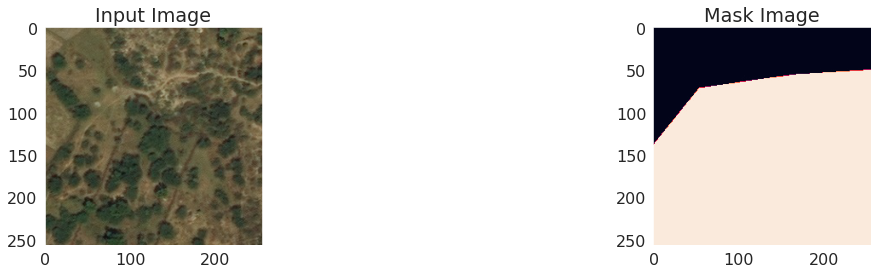

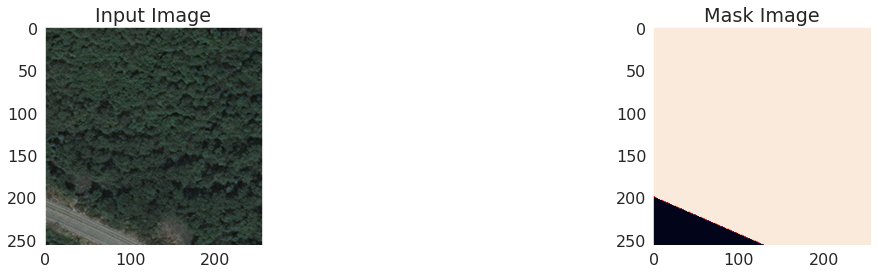

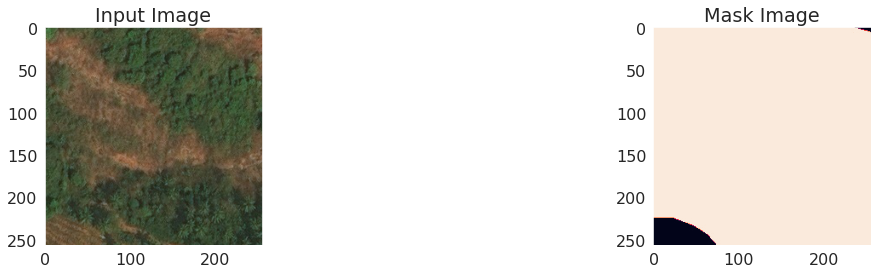

In [ ]:
# see the visualization
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 3:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        x = np.squeeze(mask[0])
        axs[1].imshow(x)
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

## Architecture

It's time for constructing the architecture for our model. This time, we will be using the U-Net Architecture as our reference. 

<img src = 'https://miro.medium.com/max/1400/1*0IaZQvDNAdf1LFqfygZtrQ.png'>



The picture above tells about the structure of U-Net. We follow this structure, where there will be:
- 4x downs -> inside each down, there are 2x Conv + ReLU. (we will use batch normalization too). this will be followed by maxPooling which downsample the feature map into its half.
- bottleneck -> 2x Conv + ReLU.
- 4x ups -> will do Transpose conv (+ concatenate) where TC do upsampling, making the feature map doubled. followed by 2x Conv + ReLU (same as downs).
- softMax -> sigmoid activation.

> the feature maps in the decoder (upsampling // ups) section will also consider having useful information, so we concatenate them with the output of the transpose convolution operation while upsampling so the information still can be used to predict the segmentation masks.





more about concatination:
> combines spatial information from the down-sampling path with the up-sampling path to retaining good spatial information.
>
> cons: this process brings along poor feature representation from the initial layers. **>> A PROBLEM <<**

In [ ]:
# architecture
def convBlock(input, num_filters): # Conv - BatchNorm - ReLU (2x)
    x = Conv2D(num_filters, 3, padding="same")(input) # padding same meaning the pixel at the output wont change
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoderBlock(input, num_filters): # perform convBlock + MaxPool (1x down)
    x = convBlock(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoderBlock(input, skip_features, num_filters): # perform TransposeConv + Concatenate + convBlock (1x up)
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features]) # It takes as input a list of tensors, all of the same shape except for the concatenation axis, 
                                          # and returns a single tensor that is the concatenation of all inputs.
    x = convBlock(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    # 4x downs 
    s1, p1 = encoderBlock(inputs, 32) 
    s2, p2 = encoderBlock(p1, 64)
    s3, p3 = encoderBlock(p2, 128)
    s4, p4 = encoderBlock(p3, 256)

    # bottleneck
    b1 = convBlock(p4, 512)

    # 4x ups -> the input and output pixel is have to be the same (but in grayscale)
    d1 = decoderBlock(b1, s4, 256)
    d2 = decoderBlock(d1, s3, 128)
    d3 = decoderBlock(d2, s2, 64)
    d4 = decoderBlock(d3, s1, 32)

    # final_conv // softmax
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

Then, to evaluate our semantic segmentation model, we use IoU Coefficient.
> To define the term, in Machine Learning, IoU means Intersection over Union - a metric used to evaluate Deep Learning algorithms by estimating how well a predicted mask or bounding box matches the ground truth data. 
>
> The Intersection over Union (IoU) metric, also referred to as the Jaccard index, is essentially a method to quantify the percent overlap between the target mask and our prediction output.

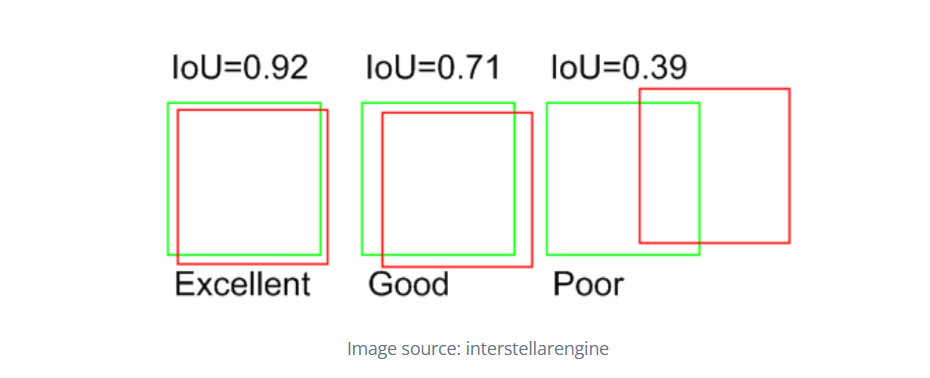

In [ ]:
# IoU coefs.
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

## Training

We will define the model and set its remaining hyperparameters. We use 0.001 for learning rate, BinaryCrossEntropy for calculating the loss function (optimization) -- because there will be two label (black-white), and IoU & Accuracy as the metrics to train the model.

In [ ]:
input_shape = (img_dim, img_dim, 3)
model = build_unet(input_shape)
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = ['binary_crossentropy'], metrics=[iou_coef,'accuracy'])

# display the summary of our model
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 batch_normalization_13 (BatchN  (None, 64, 64, 128)  512        ['conv2d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 64, 64, 128)  0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 128, 128, 64  32832      ['activation_13[0][0]']          
 spose)                         )                                                                 
                                                                                                  
 concatenate_2 (Concatenate)    (None, 128, 128, 12  0           ['conv2d_transpose_2[0][0]',     
                                8)                                'activation_3[0][0]']           
          

then, add required callbacks: checkpoint to save our model, and earlystop to do earlystopping when we do the training process.

the model will be saved as "unet.h5".

In [ ]:
model_path = "unet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

Let's do the training process!

We use 3 epochs as a starter. *this number is used because we have limited time. 

In [ ]:
# training 
history = model.fit(train_generator,
                    steps_per_epoch=training_samples_size//32,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//32,
                    epochs=3, callbacks=[earlystop, checkpoint])

Epoch 1/3
143/143 [==============================] - ETA: 0s - loss: 0.4998 - iou_coef: 0.5187 - accuracy: 0.7613
Epoch 00001: val_loss improved from inf to 17.15035, saving model to unet.h5
143/143 [==============================] - 1330s 9s/step - loss: 0.4998 - iou_coef: 0.5187 - accuracy: 0.7613 - val_loss: 17.1503 - val_iou_coef: 0.0020 - val_accuracy: 0.3946
Epoch 2/3
143/143 [==============================] - ETA: 0s - loss: 0.4520 - iou_coef: 0.5506 - accuracy: 0.7912
Epoch 00002: val_loss improved from 17.15035 to 5.29404, saving model to unet.h5
143/143 [==============================] - 104s 685ms/step - loss: 0.4520 - iou_coef: 0.5506 - accuracy: 0.7912 - val_loss: 5.2940 - val_iou_coef: 0.0181 - val_accuracy: 0.4052
Epoch 3/3
143/143 [==============================] - ETA: 0s - loss: 0.4381 - iou_coef: 0.5570 - accuracy: 0.7978
Epoch 00003: val_loss improved from 5.29404 to 1.10385, saving model to unet.h5
143/143 [==============================] - 102s 711ms/step - loss: 

Higher IoU value means better performance. from the result above, we get  poor IoU value which means that our prediction output might not able to resemble the target mask very much. The loss value is keep decreasing which is good, we should train the model with more epochs. the accuracy is also quite high which is also good.

## Inference

In [ ]:
# for plotting style
import seaborn as sns
sns.set_style('dark')

### Learning Curve

First, we will see the learning curve of our model post-training (although there might be not much we can infer). 

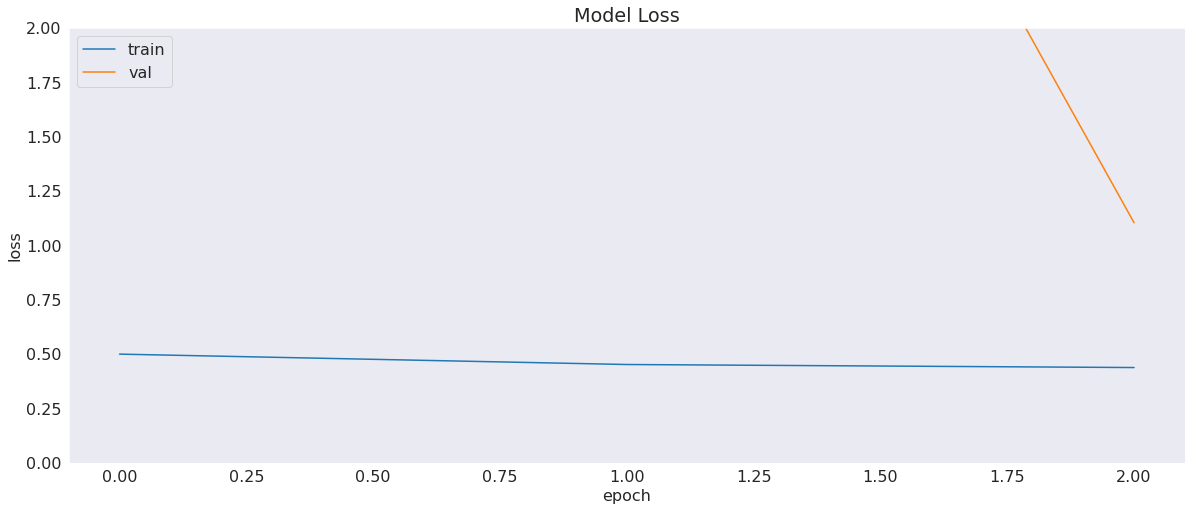

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

this results clearly said that we should do more epochs on training!

BUT, we will continue into testing...

In [ ]:
# testing our model to val dataset
random_val_samples = val_generator.__next__()
val_image_samples = random_val_samples[0]
val_mask_samples = random_val_samples[1]
predicted_masks = model.predict(val_image_samples)

# round
predicted_masks[predicted_masks >= 0.5] = 1
predicted_masks[predicted_masks < 0.5] = 0

1/1 [==============================] - 0s 39ms/step


## Ground Truth Masks vs. Predicted Masks

This time, we will see the visualization of the ground truth masks versus the predicted masks. 

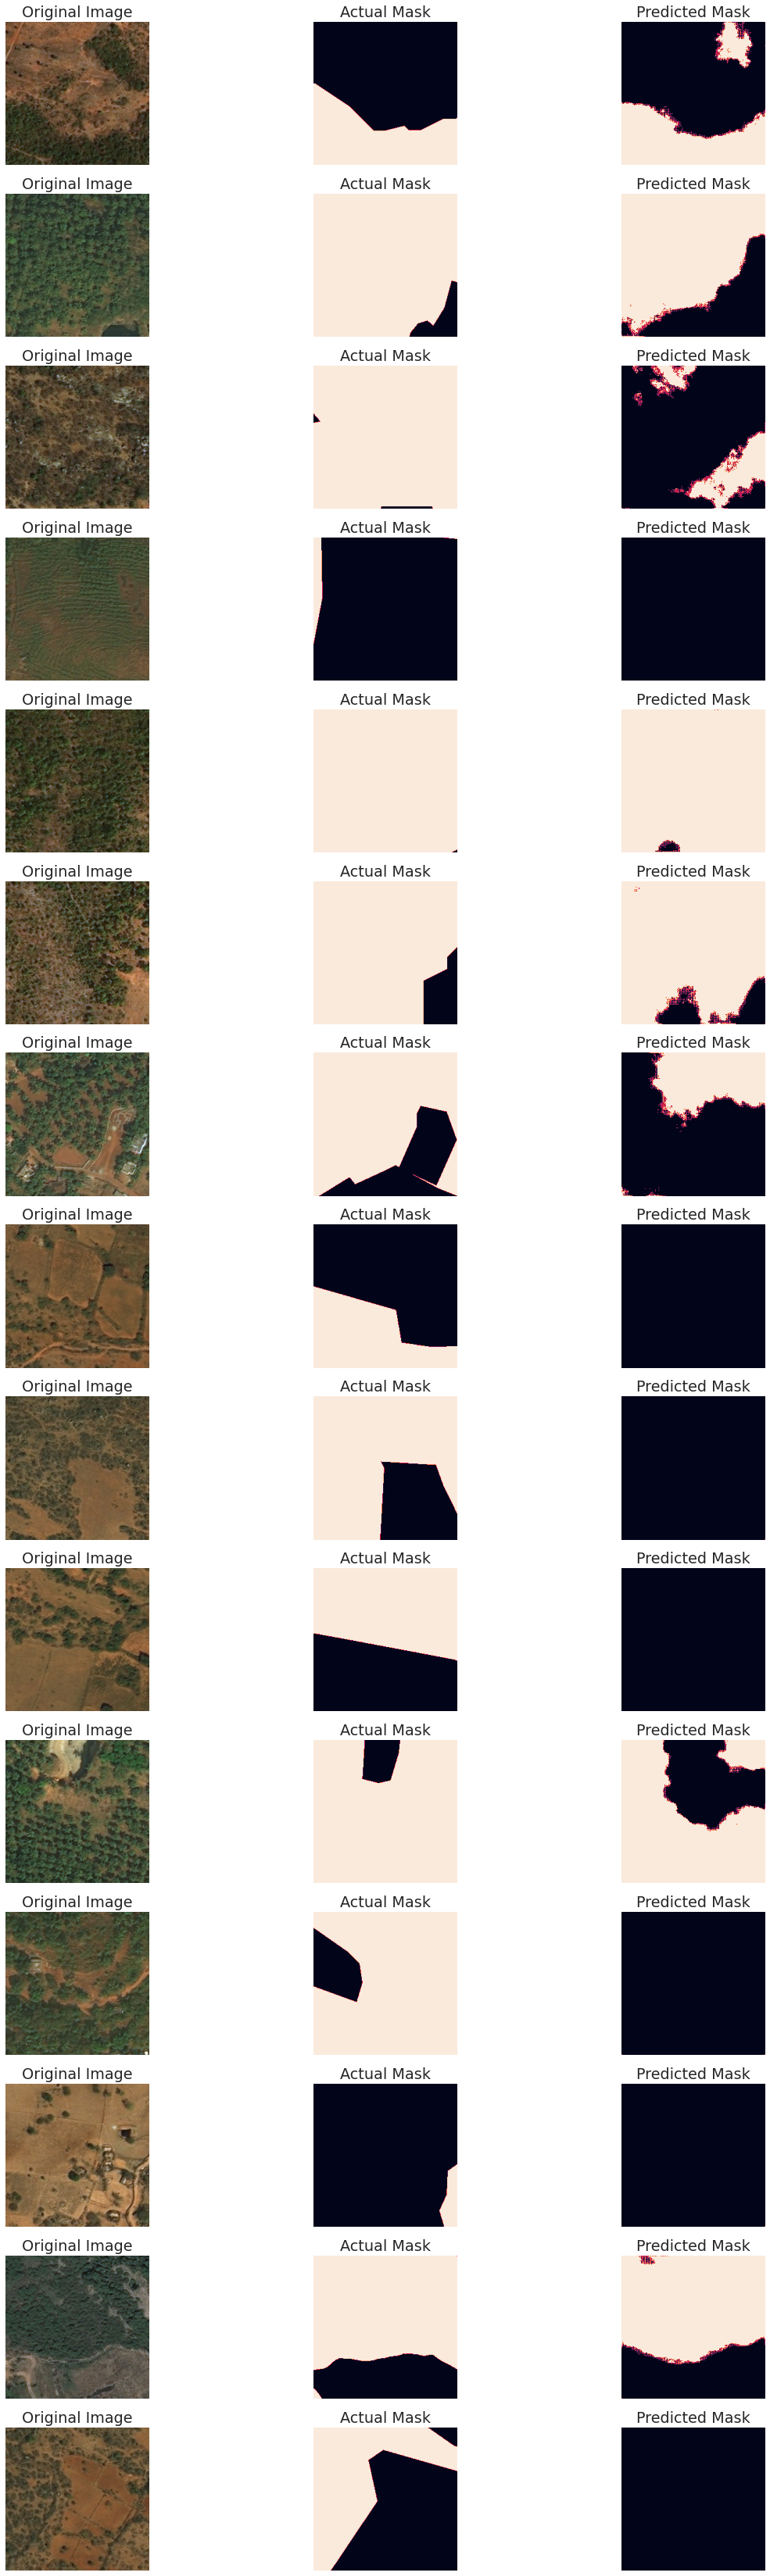

In [ ]:
f, axarr = plt.subplots(15,3,figsize=(20, 60))

for i in range(0,15):

    axarr[i,0].imshow(val_image_samples[i])
    axarr[i,0].title.set_text('Original Image')
    axarr[i,0].axis('off')
    x = np.squeeze(val_mask_samples[i])
    axarr[i,1].imshow(x)
    # axarr[i,1].imshow(val_mask_samples[i])
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,1].axis('off')
    y = np.squeeze(predicted_masks[i])
    axarr[i,2].imshow(y)
    # axarr[i,2].imshow(predicted_masks[i])
    axarr[i,2].title.set_text('Predicted Mask')
    axarr[i,2].axis('off')

### Conclusion

- It is clearly shown that a lot of segmented masks did not match the actual/grown truth mask. the reason behind this is some image might not properlly labelled. Moreover, there are several segemented masks that could not detech any forest area (where there should be any). 
- However, the overall performance of our model can be improved by adding more epoch in the training process -- Or, we can try adding attention into the model. 

### Attention

Actually, it is required to add attention layer to the model, making Attention based U-Net. However, I still could not overcome the problem i've encountered when trying to apply the attention. So, I will explain the theory side only.

Attention, in the context of image segmentation, is used for **highlighting the relevant activations** during training. This application reduces the computational resources wasted on irrelevant activations, implying on better generalization power on the network.

> essentially, the network can pay "attention" to certain parts of the image.

There are two types of attention:
- **hard attention**: 
> highlight relevant regions by cropping
>
> one region at a time (implying that it is non-differentiable and need reinforcement learning)
>
> network can be pay attention or not (cant in between)
>
> backpropagation cannot be used.
- **soft attention**: adds weights to pixels based on its relevance. 
> weighting different parts of the image
>
> relevant part images get large weights while less relevant ones get small weights
>
> can be trained using backpropagation
>
> the weights also get trained making model pay more attention to relevant regions while training process is running.

Hence, we will implement **SOFT ATTENTION** to the skip-connection parts or BEFORE each time we do the ups / upsampling process in our current U-Net Architecture. This **SOFT ATTENTION** will actively supress activation at irrelevant regions.

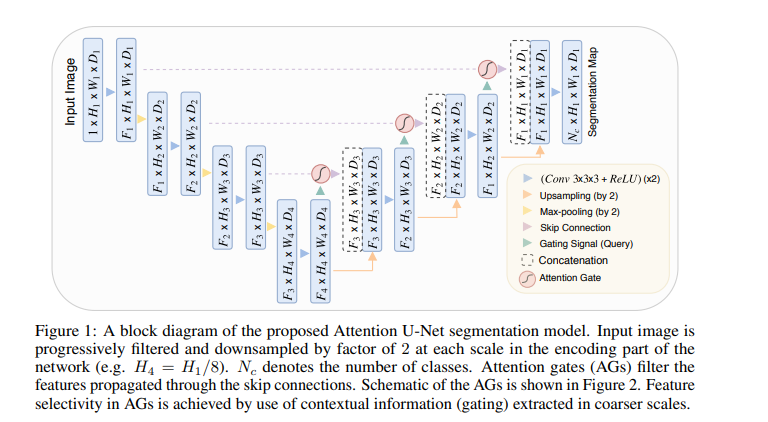

Reference:
- https://www.kaggle.com/code/quadeer15sh/how-to-perform-semantic-segmentation-using-u-net/notebook#What-is-Image-Segmentation-?
- https://hasty.ai/docs/mp-wiki/metrics/iou-intersection-over-union
- https://towardsdatascience.com/a-detailed-explanation-of-the-attention-u-net-b371a5590831 
- https://smcdonagh.github.io/papers/attention_u_net_learning_where_to_look_for_the_pancreas.pdf 


#### CODE DIBAWAH TIDAK DIPAKAI!!!

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=3)(conv)
    conv = Activation("relu")(conv)

    conv = Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=3)(conv)
    conv = Activation("relu")(conv)
    
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=3)(conv)
    conv = Activation('relu')(conv)
    
    conv = Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=3)(conv)
    #conv = Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = BatchNormalization(axis=3)(shortcut)

    res_path = add([shortcut, conv])
    res_path = Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# attention layer
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = multiply([upsample_psi, x])

    result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = BatchNormalization()(result)
    return result_bn

In [ ]:
def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = MaxPool2D((2, 2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = MaxPool2D((2, 2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = MaxPool2D((2, 2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = MaxPool2D((2, 2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = concatenate([up_128, att_128], axis=3) 
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = BatchNormalization(axis=3)(conv_final)
    conv_final = Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = Model(inputs, conv_final, name="Attention_UNet")
    return model


In [ ]:
input_shape = (img_dim, img_dim, 3)
model2 = Attention_UNet(input_shape)
model2.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = ['binary_crossentropy'], metrics=[iou_coef,'accuracy'])
model2.summary()

NameError: ignored